In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import scipy.stats as si
import pandas as pd
import seaborn as sns
sns.set_style("whitegrid")

In [ ]:
#hard inputs
S_one=20
S_two=20

rf=0.03

s1=0.3
s2=0.1

corr=-0.5

q1=0.01
q2=0.01

T=1 # years

### Stocks distribution

In [ ]:
np.random.seed(42)
S1_T_dist=[]
S2_T_dist=[]
for i in range(1,1000):

  Z1=np.random.standard_normal()
  Z2=np.random.standard_normal()

  S1_T_dist.append(S_one * np.exp((rf - q1 - (s1 ** 2) / 2) * T + s1 * np.sqrt(T) * Z1))
  S2_T_dist.append(S_two * np.exp((rf - q2 - (s2 ** 2) / 2) * T + s2 * np.sqrt(T) * (corr * Z1 + np.sqrt(1 - corr ** 2) * Z2)))



/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


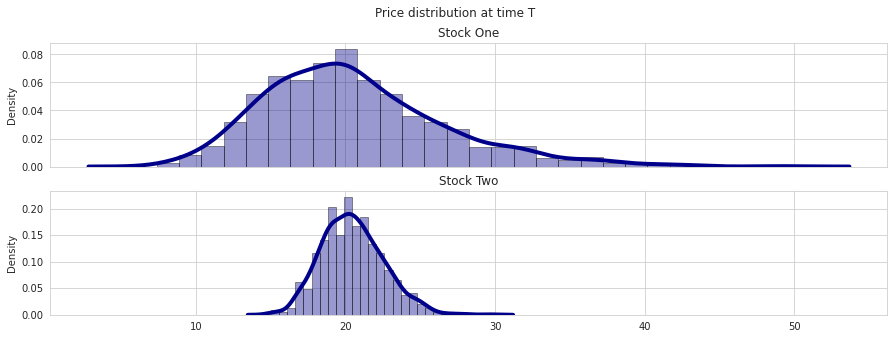

In [ ]:
sns.set_style("whitegrid")

fig, axes = plt.subplots(2, 1, figsize=(15, 5), sharex=True)
fig.suptitle('Price distribution at time T')

sns.distplot(S1_T_dist, hist=True, kde=True, 
    bins="auto", color = 'darkblue', 
    hist_kws={'edgecolor':'black'},
    kde_kws={'linewidth': 4},
            ax=axes[0],)
axes[0].set_title("Stock One")

sns.distplot(S2_T_dist, hist=True, kde=True, 
    bins="auto", color = 'darkblue', 
    hist_kws={'edgecolor':'black'},
    kde_kws={'linewidth': 4},
    ax=axes[1])
axes[1].set_title("Stock Two")

plt.show()

### Closed formula pricing


In [ ]:
# closed formula

def closed(S_one, S_two, s1, s2, corr, q1, q2,T):
  sigma_tot=np.sqrt((s1**2) + (s2**2) - (2 * s1 * s2 * corr))
  
  d1 = (np.log(S_one/S_two) + (q2-q1+(sigma_tot**2)/2)*T)/(sigma_tot*np.sqrt(T))
  
  d2 = d1 - sigma_tot * np.sqrt(T)

  option_value = ((S_one * (np.exp(-q1*T))) * norm.cdf(d1)) - (S_two * np.exp(-q2*T) * norm.cdf(d2))

  return option_value

In [ ]:
closed(S_one, S_two, s1, s2, corr, q1, q2, T)

2.832836151253318

### Montecarlo simulation

In [ ]:
def Monte(n, i):
  while i<n:
    Z1=np.random.standard_normal()
    Z2=np.random.standard_normal()
    S1_T= S_one * np.exp((rf - q1 - (s1 ** 2) / 2) * T + s1 * np.sqrt(T) * Z1)
    S2_T= S_two * np.exp((rf - q2 - (s2 ** 2) / 2) * T + s2 * np.sqrt(T) * (corr * Z1 + np.sqrt(1 - corr ** 2) * Z2))

    payoff=S1_T-S2_T

    if payoff>0:
      values.append(payoff*np.exp(-rf*T))  

    else:
      values.append(0)
    i+=1

In [ ]:
np.random.seed(42)
rep=np.arange(5, 10001, 50)
results=[]
CI_95_low=[]
CI_95_high=[]
CI_99_low=[]
CI_99_high=[]

for n in rep:
  i=0
  values=[]
  Monte(n, i)
  mean_values=np.mean(values)
  results.append(mean_values)

  CI_95_low.append(mean_values - np.std(values) * 1.96 / np.sqrt(n))
  CI_95_high.append(mean_values + np.std(values) * 1.96 / np.sqrt(n))
  CI_99_low.append(mean_values - np.std(values) * 2.576 / np.sqrt(n))
  CI_99_high.append(mean_values + np.std(values) * 2.576 / np.sqrt(n))  

final=pd.DataFrame([rep, results, CI_95_low, CI_95_high, CI_99_low, CI_99_high]).T
final.columns=["repetitions", "price", "CI_95_low", "CI_95_high", "CI_99_low", "CI_99_high" ]
final

,repetitions,price,CI_95_low,CI_95_high,CI_99_low,CI_99_high
0,5.0,3.030240,-0.567896,6.628376,-1.698739,7.759219
1,55.0,1.757206,0.886833,2.627579,0.613287,2.901125
2,105.0,3.018688,2.055954,3.981421,1.753381,4.283994
3,155.0,2.881784,2.093009,3.670559,1.845108,3.918459
4,205.0,2.902886,2.231517,3.574255,2.020515,3.785256
...,...,...,...,...,...,...
195,9755.0,2.831442,2.736977,2.925907,2.707288,2.955596
196,9805.0,2.853422,2.758202,2.948643,2.728275,2.978569
197,9855.0,2.842256,2.747241,2.937271,2.717379,2.967133
198,9905.0,2.822278,2.728954,2.915602,2.699624,2.944932


In [ ]:
closed_formula_price=closed(S_one, S_two, s1, s2, corr, q1, q2, T)

In [ ]:
final["rel_error"]=final.price.apply(lambda x: np.abs(x - closed_formula_price)/x)

In [ ]:
final

,repetitions,price,CI_95_low,CI_95_high,CI_99_low,CI_99_high,rel_error
0,5.0,3.030240,-0.567896,6.628376,-1.698739,7.759219,0.065145
1,55.0,1.757206,0.886833,2.627579,0.613287,2.901125,0.612125
2,105.0,3.018688,2.055954,3.981421,1.753381,4.283994,0.061567
3,155.0,2.881784,2.093009,3.670559,1.845108,3.918459,0.016985
4,205.0,2.902886,2.231517,3.574255,2.020515,3.785256,0.024131
...,...,...,...,...,...,...,...
195,9755.0,2.831442,2.736977,2.925907,2.707288,2.955596,0.000492
196,9805.0,2.853422,2.758202,2.948643,2.728275,2.978569,0.007215
197,9855.0,2.842256,2.747241,2.937271,2.717379,2.967133,0.003314
198,9905.0,2.822278,2.728954,2.915602,2.699624,2.944932,0.003741


Text(0, 0.5, 'relative error')

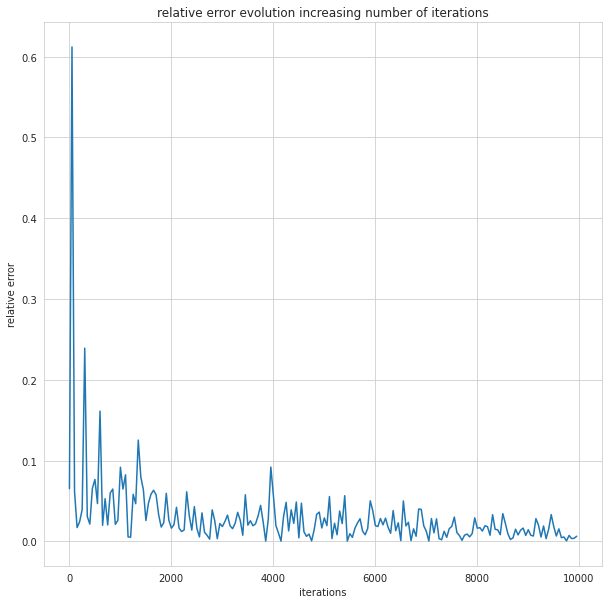

In [ ]:
plt.figure(figsize=(10,10))
plt.plot(final["repetitions"], final["rel_error"])
plt.title("relative error evolution increasing number of iterations")
plt.xlabel("iterations")
plt.ylabel('relative error')

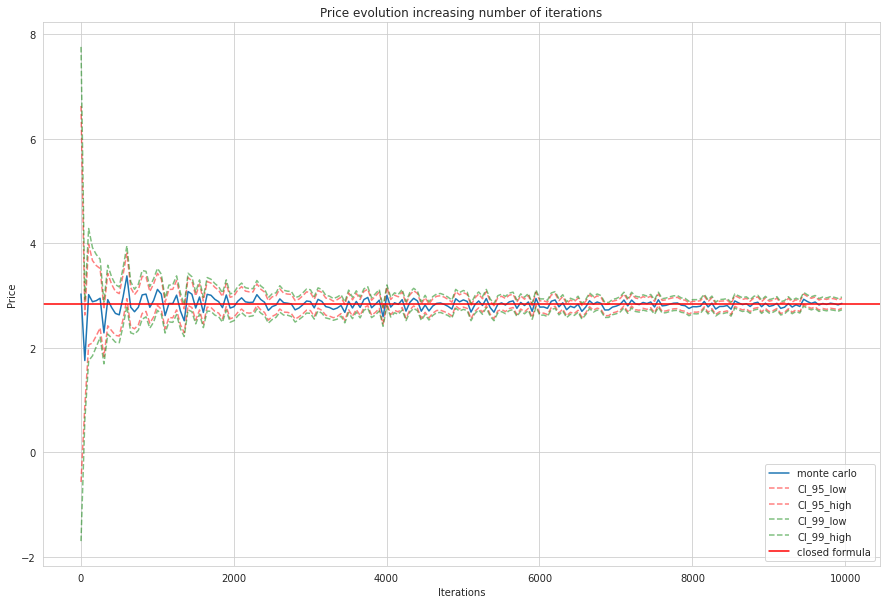

In [ ]:
import seaborn as sns
sns.set_style("whitegrid")
plt.figure(figsize=(15,10))

################
plt.title("Price evolution increasing number of iterations")
################

plt.plot(final["repetitions"], final["price"], label="monte carlo")
plt.plot(final["repetitions"], final["CI_95_low"], label="CI_95_low", linestyle="--", alpha=0.5, c="red")
plt.plot(final["repetitions"], final["CI_95_high"], label="CI_95_high", linestyle="--", alpha=0.5, c="red")
plt.plot(final["repetitions"], final["CI_99_low"], label="CI_99_low", linestyle="--", alpha=0.5, c="green")
plt.plot(final["repetitions"], final["CI_99_high"], label="CI_99_high", linestyle="--", alpha=0.5, c="green")
plt.axhline(y=closed(S_one, S_two, s1, s2, corr, q1, q2, T), color='r', linestyle='-', label="closed formula")
plt.xlabel("Iterations")
plt.ylabel("Price")
plt.legend(loc=4)

### Sensitivity analysis (correlation)

In [ ]:
corr_list=np.arange(-1, 1, 0.01)

In [ ]:
results=[]
CI_95_low=[]
CI_95_high=[]
CI_99_low=[]
CI_99_high=[]
n=10001

In [ ]:
np.random.seed(42)
for corr in corr_list:
  values=[]
  Monte(n, 0)
  mean_values=np.mean(values)
  results.append(mean_values)
  CI_95_low.append(mean_values - np.std(values) * 1.96 / np.sqrt(n))
  CI_95_high.append(mean_values + np.std(values) * 1.96 / np.sqrt(n))
  CI_99_low.append(mean_values - np.std(values) * 2.576 / np.sqrt(n))
  CI_99_high.append(mean_values + np.std(values) * 2.576 / np.sqrt(n))  

final=pd.DataFrame([corr_list, results, CI_95_low, CI_95_high, CI_99_low, CI_99_high]).T
final.columns=["correlation", "price", "CI_95_low", "CI_95_high", "CI_99_low", "CI_99_high" ]
final

,correlation,price,CI_95_low,CI_95_high,CI_99_low,CI_99_high
0,-1.00,3.195535,3.091734,3.299335,3.059111,3.331958
1,-0.99,3.133967,3.031936,3.235998,2.999870,3.268065
2,-0.98,3.195961,3.092934,3.298987,3.060554,3.331367
3,-0.97,3.153892,3.051597,3.256188,3.019447,3.288338
4,-0.96,3.165605,3.061616,3.269594,3.028933,3.302276
...,...,...,...,...,...,...
195,0.95,1.660582,1.600125,1.721040,1.581124,1.740041
196,0.96,1.644208,1.585404,1.703013,1.566922,1.721495
197,0.97,1.637775,1.577483,1.698067,1.558534,1.717016
198,0.98,1.577372,1.519167,1.635578,1.500874,1.653871


In [ ]:
final["closed_formula_value"]=final["correlation"].apply(lambda x: closed(S_one, S_two, s1, s2, x, q1, q2, T))

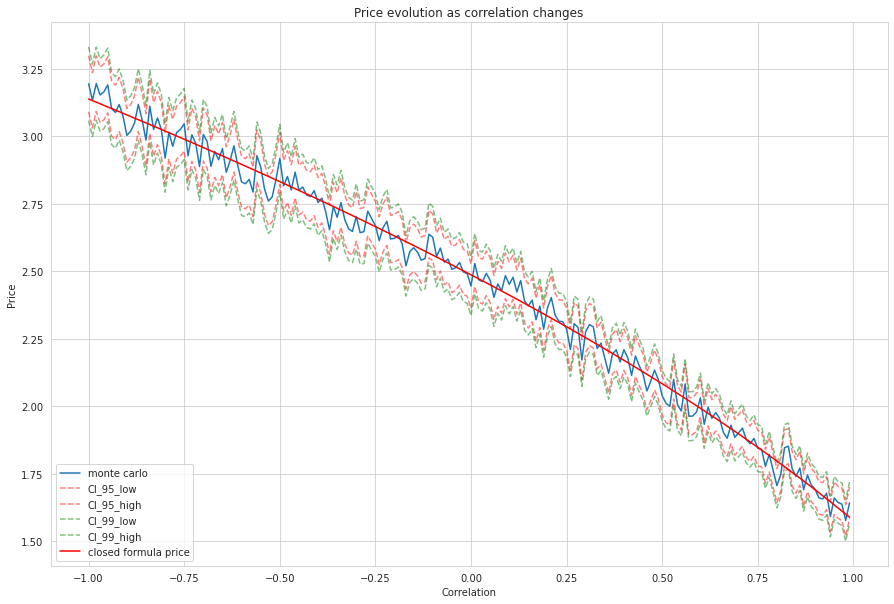

In [ ]:
import seaborn as sns
sns.set_style("whitegrid")
plt.figure(figsize=(15,10))

##########################
plt.title("Price evolution as correlation changes")
##########################

plt.plot(final["correlation"], final["price"], label="monte carlo")
plt.plot(final["correlation"], final["CI_95_low"], label="CI_95_low", linestyle="--", alpha=0.5, c="red")
plt.plot(final["correlation"], final["CI_95_high"], label="CI_95_high", linestyle="--", alpha=0.5, c="red")
plt.plot(final["correlation"], final["CI_99_low"], label="CI_99_low", linestyle="--", alpha=0.5, c="green")
plt.plot(final["correlation"], final["CI_99_high"], label="CI_99_high", linestyle="--", alpha=0.5, c="green")
plt.plot(final["correlation"], final["closed_formula_value"], label="closed formula price", c="red")
plt.ylabel("Price")
plt.xlabel("Correlation")
plt.legend(loc=3)

### Sensitivity analysis (sigma 1 and sigma 2)


correlation = -0.5

In [ ]:
corr=-0.5

In [ ]:
s1_list=np.arange(0.01, 0.5, 0.01)
s2_list=np.arange(0.01, 0.5, 0.01)

In [ ]:
results=[]
CI_95_low=[]
CI_95_high=[]
CI_99_low=[]
CI_99_high=[]
s1_data=[]
s2_data=[]
n=10001

In [ ]:
np.random.seed(42)
for s1 in s1_list:
  for s2 in s2_list:
    values=[]
    Monte(n, 0)
    mean_values=np.mean(values)
    results.append(mean_values)
    CI_95_low.append(mean_values - np.std(values) * 1.96 / np.sqrt(n))
    CI_95_high.append(mean_values + np.std(values) * 1.96 / np.sqrt(n))
    CI_99_low.append(mean_values - np.std(values) * 2.576 / np.sqrt(n))
    CI_99_high.append(mean_values + np.std(values) * 2.576 / np.sqrt(n))  
    s1_data.append(s1)
    s2_data.append(s2)

final=pd.DataFrame([s1_data, s2_data, results, CI_95_low, CI_95_high, CI_99_low, CI_99_high]).T
final.columns=["s1", "s2", "price", "CI_95_low", "CI_95_high", "CI_99_low", "CI_99_high" ]
final

,s1,s2,price,CI_95_low,CI_95_high,CI_99_low,CI_99_high
0,0.01,0.01,0.237153,0.230356,0.243950,0.228220,0.246086
1,0.01,0.02,0.362375,0.352217,0.372533,0.349024,0.375726
2,0.01,0.03,0.509189,0.494869,0.523509,0.490369,0.528009
3,0.01,0.04,0.622649,0.605315,0.639983,0.599868,0.645431
4,0.01,0.05,0.759152,0.737935,0.780369,0.731267,0.787037
...,...,...,...,...,...,...,...
2396,0.49,0.45,10.581076,10.242047,10.920104,10.135495,11.026656
2397,0.49,0.46,10.992286,10.647545,11.337027,10.539198,11.445374
2398,0.49,0.47,10.883371,10.539279,11.227463,10.431135,11.335607
2399,0.49,0.48,11.380052,11.018315,11.741788,10.904626,11.855477


Text(0.5, 0.92, 'Correlation = -0.5')

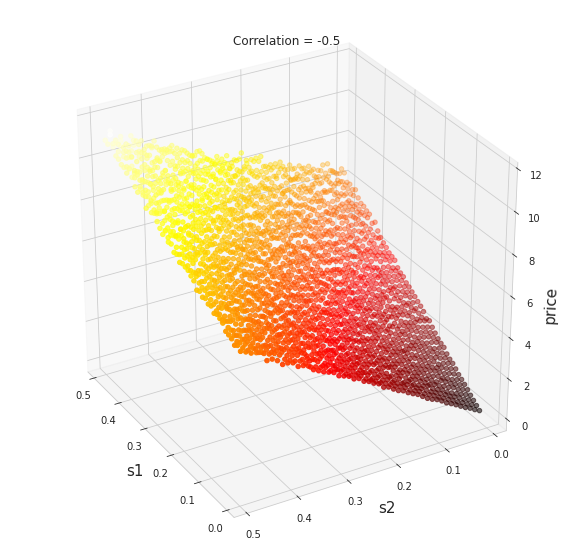

In [ ]:
fig = plt.figure(figsize=(10,10))

ax = plt.axes(projection='3d')

ax.scatter3D(final["s1"], final["s2"], final["price"], c=final["price"], cmap='hot')

ax.view_init(30, 150)

ax.set_xlabel('s1', fontsize=15)

ax.set_ylabel('s2', fontsize=15)

ax.set_zlabel("price", fontsize=15)

plt.title("Correlation = -0.5")

In [ ]:
closed_formula_values=[]
for i in final.index:
  s1=final.iloc[i, 0]
  s2=final.iloc[i, 1]
  g=closed(S_one, S_two, s1,s2, corr, q1,q2,T)
  closed_formula_values.append(g)
final["closed_formula_value"]=closed_formula_values

rel_error=[]
for i in final.index:
  x=final.iloc[i, 2]
  y=final.iloc[i, 7] 
  rel_error.append(np.abs(x - y)/x)

final["rel_error"]= rel_error

In [ ]:
final

,s1,s2,price,CI_95_low,CI_95_high,CI_99_low,CI_99_high,closed_formula_value,rel_error
0,0.01,0.01,0.237153,0.230356,0.243950,0.228220,0.246086,0.236016,0.004795
1,0.01,0.02,0.362375,0.352217,0.372533,0.349024,0.375726,0.360514,0.005135
2,0.01,0.03,0.509189,0.494869,0.523509,0.490369,0.528009,0.491286,0.035160
3,0.01,0.04,0.622649,0.605315,0.639983,0.599868,0.645431,0.624393,0.002800
4,0.01,0.05,0.759152,0.737935,0.780369,0.731267,0.787037,0.758597,0.000731
...,...,...,...,...,...,...,...,...,...
2396,0.49,0.45,10.581076,10.242047,10.920104,10.135495,11.026656,10.797133,0.020419
2397,0.49,0.46,10.992286,10.647545,11.337027,10.539198,11.445374,10.904295,0.008005
2398,0.49,0.47,10.883371,10.539279,11.227463,10.431135,11.335607,11.011674,0.011789
2399,0.49,0.48,11.380052,11.018315,11.741788,10.904626,11.855477,11.119252,0.022917


Text(0.5, 0.92, 'Relative error distribution ; Correlation = -0.5')

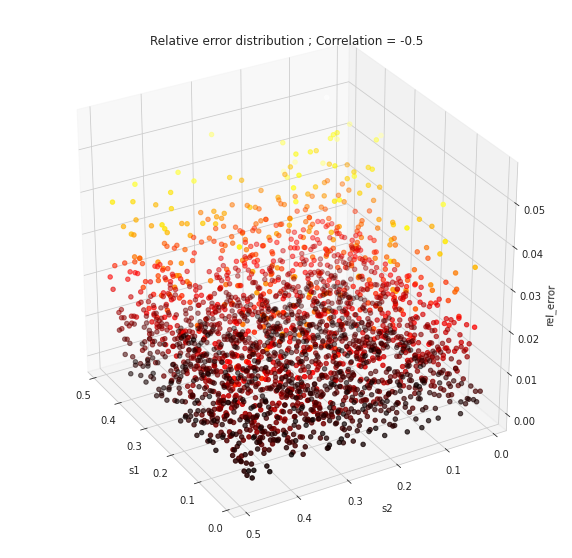

In [ ]:
fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection='3d')

ax.scatter3D(final["s1"], final["s2"], final["rel_error"], c=final["rel_error"], cmap='hot')

ax.view_init(30, 150)

ax.set_xlabel('s1')

ax.set_ylabel('s2')

ax.set_zlabel("rel_error")

plt.title("Relative error distribution ; Correlation = -0.5")

correlation =  +0.5


In [ ]:
corr=0.5

In [ ]:
s1_list=np.arange(0.01, 0.5, 0.01)
s2_list=np.arange(0.01, 0.5, 0.01)

In [ ]:
results=[]
CI_95_low=[]
CI_95_high=[]
CI_99_low=[]
CI_99_high=[]
s1_data=[]
s2_data=[]
n=10001

In [ ]:
np.random.seed(42)
for s1 in s1_list:
  for s2 in s2_list:
    values=[]
    Monte(n,0)
    mean_values=np.mean(values)
    results.append(mean_values)
    CI_95_low.append(mean_values - np.std(values) * 1.96 / np.sqrt(n))
    CI_95_high.append(mean_values + np.std(values) * 1.96 / np.sqrt(n))
    CI_99_low.append(mean_values - np.std(values) * 2.576 / np.sqrt(n))
    CI_99_high.append(mean_values + np.std(values) * 2.576 / np.sqrt(n))  
    s1_data.append(s1)
    s2_data.append(s2)

final=pd.DataFrame([s1_data, s2_data, results, CI_95_low, CI_95_high, CI_99_low, CI_99_high]).T
final.columns=["s1", "s2", "price", "CI_95_low", "CI_95_high", "CI_99_low", "CI_99_high" ]
final

,s1,s2,price,CI_95_low,CI_95_high,CI_99_low,CI_99_high
0,0.01,0.01,0.135045,0.131161,0.138928,0.129941,0.140148
1,0.01,0.02,0.239122,0.232435,0.245808,0.230334,0.247909
2,0.01,0.03,0.366165,0.355806,0.376523,0.352551,0.379778
3,0.01,0.04,0.486929,0.473447,0.500411,0.469209,0.504649
4,0.01,0.05,0.618930,0.601642,0.636218,0.596208,0.641652
...,...,...,...,...,...,...,...
2396,0.49,0.45,6.180614,5.968112,6.393116,5.901326,6.459902
2397,0.49,0.46,6.470104,6.256056,6.684152,6.188784,6.751424
2398,0.49,0.47,6.383788,6.172275,6.595302,6.105799,6.661778
2399,0.49,0.48,6.694871,6.466719,6.923023,6.395014,6.994728


Text(0.5, 0.92, 'Correlation = +0.5')

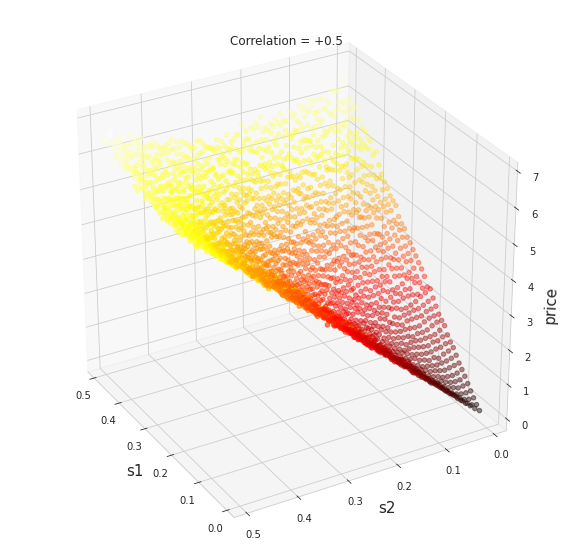

In [ ]:
fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection='3d')

ax.scatter3D(final["s1"], final["s2"], final["price"], c=final["price"], cmap='hot')

ax.view_init(30, 150)

ax.set_xlabel('s1', fontsize=15)

ax.set_ylabel('s2', fontsize=15)

ax.set_zlabel("price", fontsize=15)

plt.title("Correlation = +0.5")

In [ ]:
final

,s1,s2,price,CI_95_low,CI_95_high,CI_99_low,CI_99_high
0,0.01,0.01,0.135045,0.131161,0.138928,0.129941,0.140148
1,0.01,0.02,0.239122,0.232435,0.245808,0.230334,0.247909
2,0.01,0.03,0.366165,0.355806,0.376523,0.352551,0.379778
3,0.01,0.04,0.486929,0.473447,0.500411,0.469209,0.504649
4,0.01,0.05,0.618930,0.601642,0.636218,0.596208,0.641652
...,...,...,...,...,...,...,...
2396,0.49,0.45,6.180614,5.968112,6.393116,5.901326,6.459902
2397,0.49,0.46,6.470104,6.256056,6.684152,6.188784,6.751424
2398,0.49,0.47,6.383788,6.172275,6.595302,6.105799,6.661778
2399,0.49,0.48,6.694871,6.466719,6.923023,6.395014,6.994728


In [ ]:
closed_formula_values=[]
for i in final.index:
  s1=final.iloc[i, 0]
  s2=final.iloc[i, 1]
  g=closed(S_one, S_two, s1,s2, corr, q1,q2,T)
  closed_formula_values.append(g)
final["closed_formula_value"]=closed_formula_values

rel_error=[]
for i in final.index:
  x=final.iloc[i, 2]
  y=final.iloc[i, 7] 
  rel_error.append(np.abs(x - y)/x)

final["rel_error"]= rel_error

In [ ]:
final

,s1,s2,price,CI_95_low,CI_95_high,CI_99_low,CI_99_high,closed_formula_value,rel_error
0,0.01,0.01,0.135045,0.131161,0.138928,0.129941,0.140148,0.136265,0.009038
1,0.01,0.02,0.239122,0.232435,0.245808,0.230334,0.247909,0.236016,0.012988
2,0.01,0.03,0.366165,0.355806,0.376523,0.352551,0.379778,0.360514,0.015431
3,0.01,0.04,0.486929,0.473447,0.500411,0.469209,0.504649,0.491286,0.008948
4,0.01,0.05,0.618930,0.601642,0.636218,0.596208,0.641652,0.624393,0.008826
...,...,...,...,...,...,...,...,...,...
2396,0.49,0.45,6.180614,5.968112,6.393116,5.901326,6.459902,6.362918,0.029496
2397,0.49,0.46,6.470104,6.256056,6.684152,6.188784,6.751424,6.421683,0.007484
2398,0.49,0.47,6.383788,6.172275,6.595302,6.105799,6.661778,6.482632,0.015484
2399,0.49,0.48,6.694871,6.466719,6.923023,6.395014,6.994728,6.545698,0.022282


Text(0.5, 0.92, 'Relative error distribution ; Correlation = +0.5')

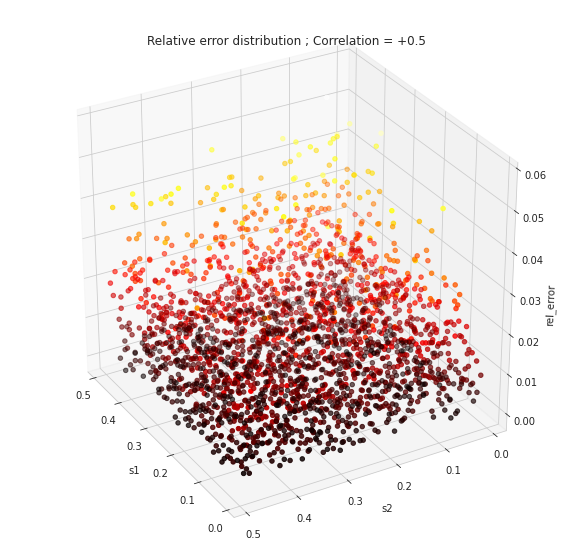

In [ ]:
fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection='3d')

ax.scatter3D(final["s1"], final["s2"], final["rel_error"], c=final["rel_error"], cmap='hot')

ax.view_init(30, 150)

ax.set_xlabel('s1')

ax.set_ylabel('s2')

ax.set_zlabel("rel_error")

plt.title("Relative error distribution ; Correlation = +0.5")

### Sensitivity analysis (S_one and S_two)

In [ ]:
corr=-0.5
s1=0.2
s2=0.2

In [ ]:
S_one_list=np.arange(5, 35 , 0.5)
S_two_list=np.arange(5, 35 , 0.5)

In [ ]:
results=[]
CI_95_low=[]
CI_95_high=[]
CI_99_low=[]
CI_99_high=[]
S_one_data=[]
S_two_data=[]
n=10001

In [ ]:
np.random.seed(42)
for S_one in S_one_list:
  for S_two in S_two_list:
    values=[]
    Monte(n,0)
    mean_values=np.mean(values)
    results.append(mean_values)
    CI_95_low.append(mean_values - np.std(values) * 1.96 / np.sqrt(n))
    CI_95_high.append(mean_values + np.std(values) * 1.96 / np.sqrt(n))
    CI_99_low.append(mean_values - np.std(values) * 2.576 / np.sqrt(n))
    CI_99_high.append(mean_values + np.std(values) * 2.576 / np.sqrt(n))  
    S_one_data.append(S_one)
    S_two_data.append(S_two)

final=pd.DataFrame([S_one_data, S_two_data, results, CI_95_low, CI_95_high, CI_99_low, CI_99_high]).T
final.columns=["S_one", "S_two", "price", "CI_95_low", "CI_95_high", "CI_99_low", "CI_99_high" ]
final

,S_one,S_two,price,CI_95_low,CI_95_high,CI_99_low,CI_99_high
0,5.0,5.0,0.685991,0.666036,0.705946,0.659764,0.712218
1,5.0,5.5,0.494545,0.477388,0.511701,0.471996,0.517094
2,5.0,6.0,0.372439,0.357113,0.387765,0.352296,0.392582
3,5.0,6.5,0.250019,0.237611,0.262427,0.233712,0.266327
4,5.0,7.0,0.181269,0.170366,0.192172,0.166939,0.195599
...,...,...,...,...,...,...,...
3595,34.5,32.5,5.733485,5.587065,5.879906,5.541047,5.925923
3596,34.5,33.0,5.349725,5.207052,5.492398,5.162212,5.537238
3597,34.5,33.5,5.127068,4.983967,5.270169,4.938992,5.315143
3598,34.5,34.0,4.872475,4.734035,5.010914,4.690525,5.054424


Text(0.5, 0, 'price')

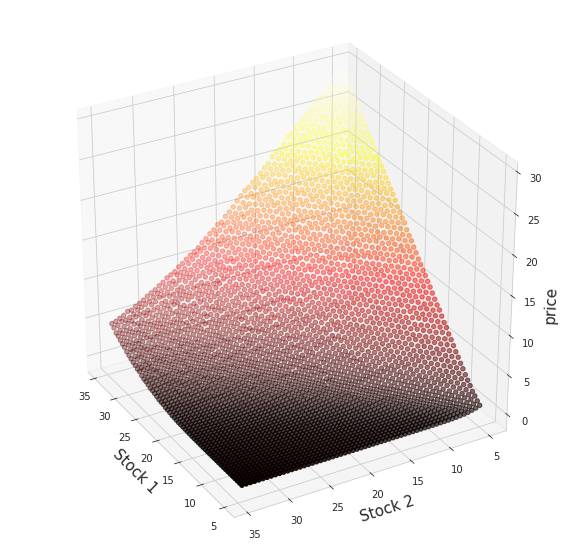

In [ ]:
fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection='3d')

ax.scatter3D(final["S_one"], final["S_two"], final["price"], c=final["price"], cmap='hot')


ax.view_init(30, 150)

ax.set_xlabel('Stock 1', fontsize=15)

ax.set_ylabel('Stock 2', fontsize=15)

ax.set_zlabel("price", fontsize=15)

In [ ]:
closed_formula_values=[]
for i in final.index:
  S_one=final.iloc[i, 0]
  S_two=final.iloc[i, 1]
  g=closed(S_one, S_two, s1 ,s2, corr, q1,q2,T)
  closed_formula_values.append(g)
final["closed_formula_value"]=closed_formula_values

rel_error=[]
for i in final.index:
  x=final.iloc[i, 2]
  y=final.iloc[i, 7] 
  rel_error.append(np.abs(x - y)/x)

final["rel_error"]= rel_error

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in double_scalars
  del sys.path[0]


In [ ]:
final[final["price"]!=0].sort_values("rel_error")

,S_one,S_two,price,CI_95_low,CI_95_high,CI_99_low,CI_99_high,closed_formula_value,rel_error
2888,29.0,9.0,19.801439,19.667468,19.935410,19.625363,19.977515,19.801513,0.000004
2256,23.5,23.0,3.418826,3.324272,3.513381,3.294554,3.543098,3.418840,0.000004
2414,25.0,12.0,12.906625,12.779785,13.033465,12.739921,13.073329,12.906689,0.000005
3036,30.0,23.0,8.067756,7.920593,8.214919,7.874341,8.261171,8.067699,0.000007
484,9.0,7.0,2.349325,2.305243,2.393408,2.291388,2.407263,2.349357,0.000013
...,...,...,...,...,...,...,...,...,...
151,6.0,20.5,0.000015,-0.000014,0.000044,-0.000023,0.000053,0.000182,11.281625
528,9.0,29.0,0.000039,-0.000038,0.000116,-0.000062,0.000140,0.000517,12.201553
340,7.5,25.0,0.000017,-0.000016,0.000051,-0.000027,0.000061,0.000299,16.473031
149,6.0,19.5,0.000012,-0.000011,0.000035,-0.000019,0.000043,0.000314,25.268386


Text(0.5, 0.92, 'Relative error distribution')

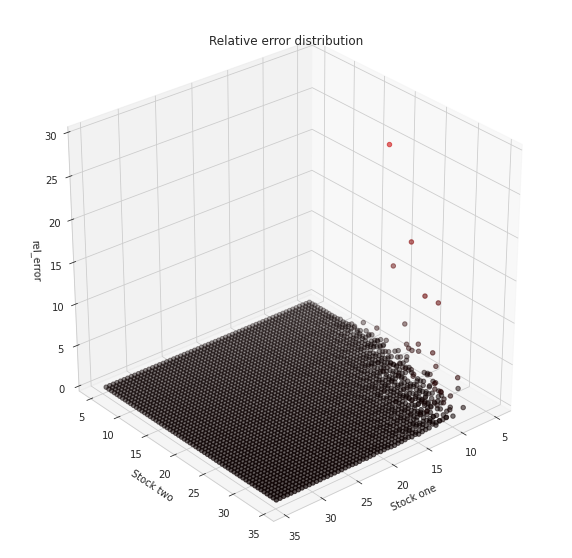

In [ ]:
fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection='3d')

ax.scatter3D(final["S_one"], final["S_two"], final["rel_error"], c=final["rel_error"], cmap='hot')

ax.view_init(30, 50)

ax.set_xlabel('Stock one')

ax.set_ylabel('Stock two')

ax.set_zlabel("rel_error")

ax.set_zlim3d(0, 30)

plt.title("Relative error distribution")

### Sensitivity analysis (q1 and q2)

In [ ]:
S_one=20
S_two=20

In [ ]:
q1_list=np.arange(0, 0.101 , 0.005)
q2_list=np.arange(0, 0.101 , 0.005)

In [ ]:
results=[]
CI_95_low=[]
CI_95_high=[]
CI_99_low=[]
CI_99_high=[]
q1_data=[]
q2_data=[]
n=10001

In [ ]:
np.random.seed(42)
for q1 in q1_list:
  for q2 in q2_list:
    values=[]
    Monte(n, 0)
    mean_values=np.mean(values)
    results.append(mean_values)
    CI_95_low.append(mean_values - np.std(values) * 1.96 / np.sqrt(n))
    CI_95_high.append(mean_values + np.std(values) * 1.96 / np.sqrt(n))
    CI_99_low.append(mean_values - np.std(values) * 2.576 / np.sqrt(n))
    CI_99_high.append(mean_values + np.std(values) * 2.576 / np.sqrt(n))  
    q1_data.append(q1)
    q2_data.append(q2)

final=pd.DataFrame([q1_data, q2_data, results, CI_95_low, CI_95_high, CI_99_low, CI_99_high]).T
final.columns=["q1", "q2", "price", "CI_95_low", "CI_95_high", "CI_99_low", "CI_99_high" ]
final

,q1,q2,price,CI_95_low,CI_95_high,CI_99_low,CI_99_high
0,0.0,0.000,2.771541,2.690918,2.852163,2.665580,2.877502
1,0.0,0.005,2.804504,2.724617,2.884392,2.699509,2.909500
2,0.0,0.010,2.927259,2.844716,3.009802,2.818774,3.035744
3,0.0,0.015,2.896973,2.815917,2.978028,2.790442,3.003503
4,0.0,0.020,2.951383,2.868368,3.034398,2.842278,3.060488
...,...,...,...,...,...,...,...
436,0.1,0.080,2.387102,2.315747,2.458456,2.293321,2.480882
437,0.1,0.085,2.396554,2.324909,2.468198,2.302392,2.490715
438,0.1,0.090,2.382381,2.311745,2.453017,2.289546,2.475217
439,0.1,0.095,2.381704,2.311324,2.452083,2.289205,2.474202


Text(0.5, 0, 'price')

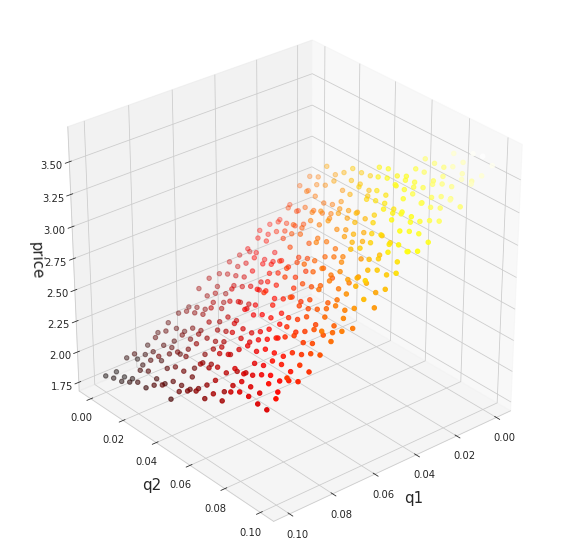

In [ ]:
fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection='3d')

ax.scatter3D(final["q1"], final["q2"], final["price"], c=final["price"], cmap='hot')

ax.view_init(30, 50)

ax.set_xlabel('q1', fontsize=15)

ax.set_ylabel('q2', fontsize=15)

ax.set_zlabel("price", fontsize=15)

In [ ]:
closed_formula_values=[]
for i in final.index:
  q1=final.iloc[i, 0]
  q2=final.iloc[i, 1]
  g=closed(S_one, S_two, s1, s2, corr, q1, q2, T)
  closed_formula_values.append(g)
final["closed_formula_value"]=closed_formula_values

rel_error=[]
for i in final.index:
  x=final.iloc[i, 2]
  y=final.iloc[i, 7] 
  rel_error.append(np.abs(x - y)/x)

final["rel_error"]= rel_error

Text(0.5, 0.92, 'Relative error distribution')

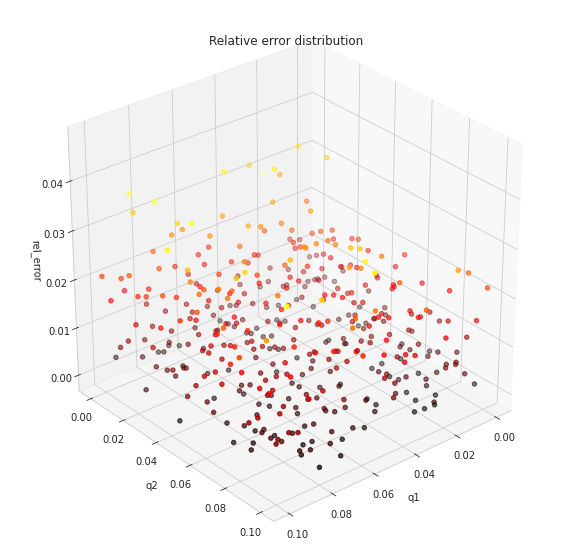

In [ ]:
fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection='3d')

ax.scatter3D(final["q1"], final["q2"], final["rel_error"], c=final["rel_error"], cmap='hot')

ax.view_init(30, 50)

ax.set_xlabel('q1')

ax.set_ylabel('q2')

ax.set_zlabel("rel_error")

plt.title("Relative error distribution")